# Past Earth Network Emulator Meeting: Lab 2


by Alan Saul and Richard Wilkinson. 

In this tutorial we will focus on combining covariance functions to get the kind of behaviour we want, and demonstrate how everything we've seen so far carries over to problems where the dimension of X is greater than 1. 

We recommend you finish the first tutorial before attempting this one.




## 1. Combining covariance functions.

We will use the classic Mauna Loa dataset of CO2 measurements through time to illustrate how we can combine different covariance functions. This example is also likely to serve as a useful illustration of how GPs can sometimes be tricky to work with, and why it is necessary to always check your fitted model.

Populating the interactive namespace from numpy and matplotlib


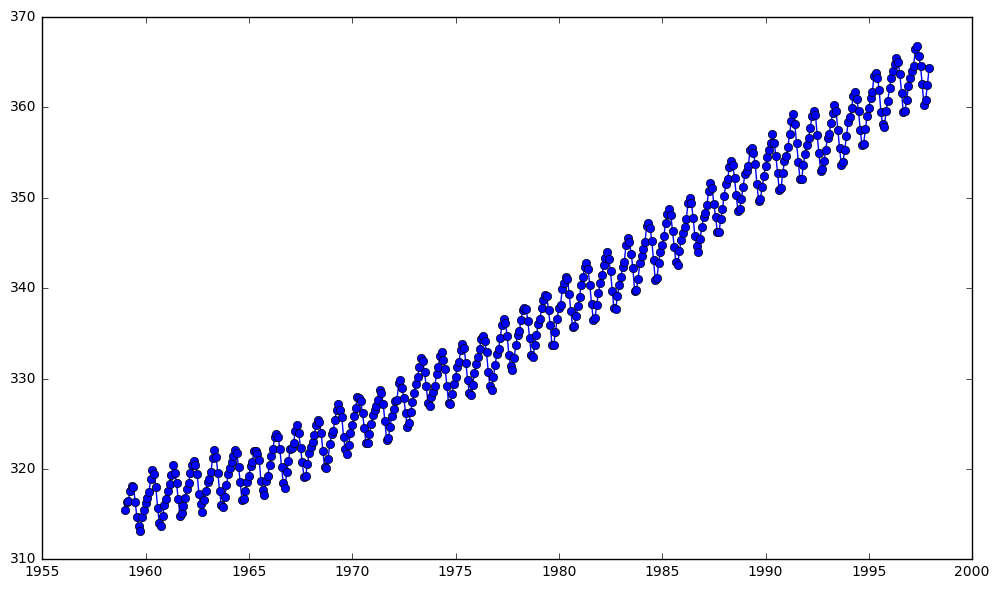

In [35]:
import GPy, numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)
%matplotlib inline
from sklearn.datasets import fetch_mldata

data = fetch_mldata('mauna-loa-atmospheric-co2').data
X = data[:, 1]
y = data[:, 0]
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 7)
plt.plot(X,y, '-o')

If we just fit a GP, then we can easily find a function that follows the general trend. But note that when we extrapolate, GPs revert to their mean, which is zero in this case. 

In [36]:
X=X[:,None] # we need to reshape X into a matrix with n rows
y=y[:,None] # we need to reshape y into a column with n rows.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


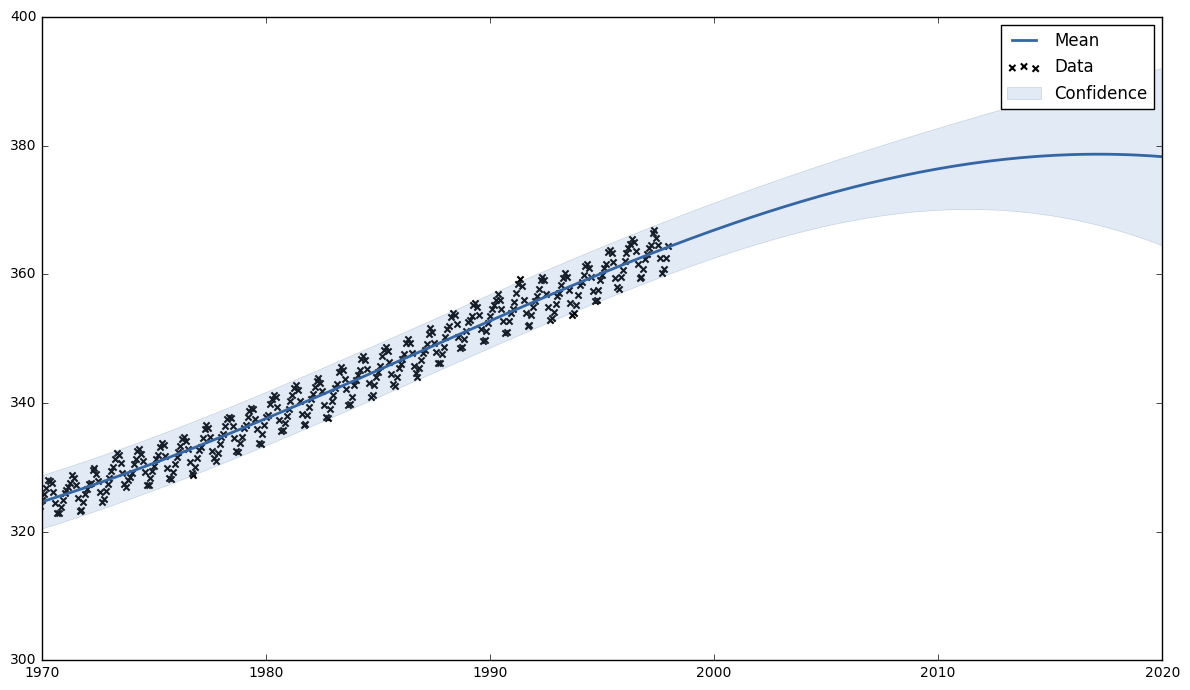

In [37]:
k1 = GPy.kern.RBF(1)
m = GPy.models.GPRegression(X,y,k1)
m.optimize()
m.plot((1970,2020))


Note that we can make the model fit the data perfectly by specifying likelihood with a very small noise term, but this model clearly has no predictive skill.

 /Users/pmzrdw/GPy/GPy/likelihoods/gaussian.py:101: RuntimeWarning:invalid value encountered in sqrt


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


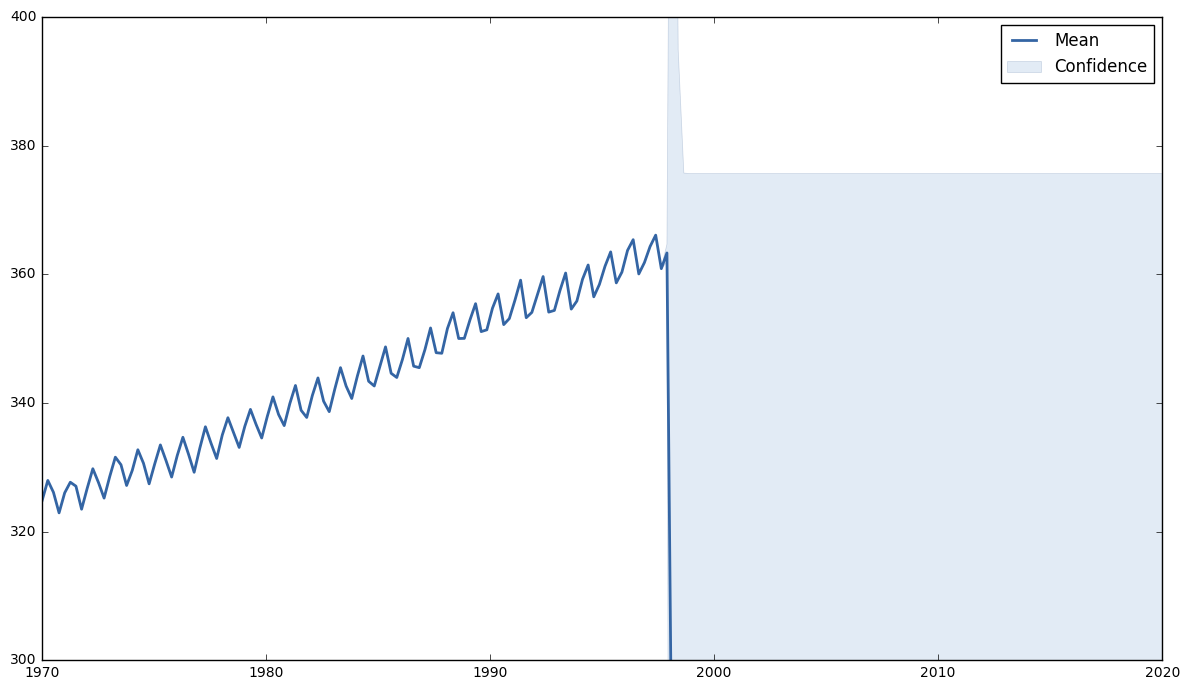

In [38]:
k2 = GPy.kern.RBF(1)
m2 = GPy.models.GPRegression(X,y,k2)
m2.likelihood.variance.constrain_fixed(0.00001)
m2.optimize()
m2.plot_f((1970,2020), ylim=(300,400))



### Exercise 1a
Check that if we predict far enough out into the future using the first GP (`m`), then the model predicts a CO2 level of 0.

How can we fix this? Well firstly, we may want to add a mean function to capture the linear increasing trend. Unfortunately GPy does not have a proper implementation of mean functions. But we can do most of the work by either

1. Faking it by fitting a linear trend, and then fitting the GP to the residual. This is cheating a little, as the linear trend will be fit using least squares regression, and so won't have accounted for the spacing between the data, but this usually does not matter.

2. Using a linear covariance function to add a linear trend.

We will use the second approach here, and in the process, we will illustrate how to combine kernels in GPy. To create a linear trend, we can combine a linear kernel and a bias kernel. This fits a model of the form
$$y = a+bx$$
to the data. To first see this without a GP, let's try the following

### Exercise 1b
Simulate prior realisations from a GPy using a bias and linear kernel. Convince yourself that the bias kernel adds a constant mean to the GP, and the linear kernel gives us a constant trend.



Combining different kernels is easy in GPy, as the + and * operators have been overloaded so that if we write something like `k1+k2` where `k1` and `k2` are both kernels, then GPy knows to do the correct calculation to give us a working covariance function. 

Optimization restart 1/5, f = 1167.5853336584914
Optimization restart 2/5, f = 1823.5205524858156
Optimization restart 3/5, f = 1445.487050064082
Optimization restart 4/5, f = 1213.7067043646693
Optimization restart 5/5, f = 1133.2507807156026

Name : GP regression
Objective : 1133.2507807156026
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  sum.linear.variances     |  12557.2434668  |      +ve      |        
  sum.bias.variance        |  2373456.68994  |      +ve      |        
  Gaussian_noise.variance  |  6.85435818449  |      +ve      |        


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


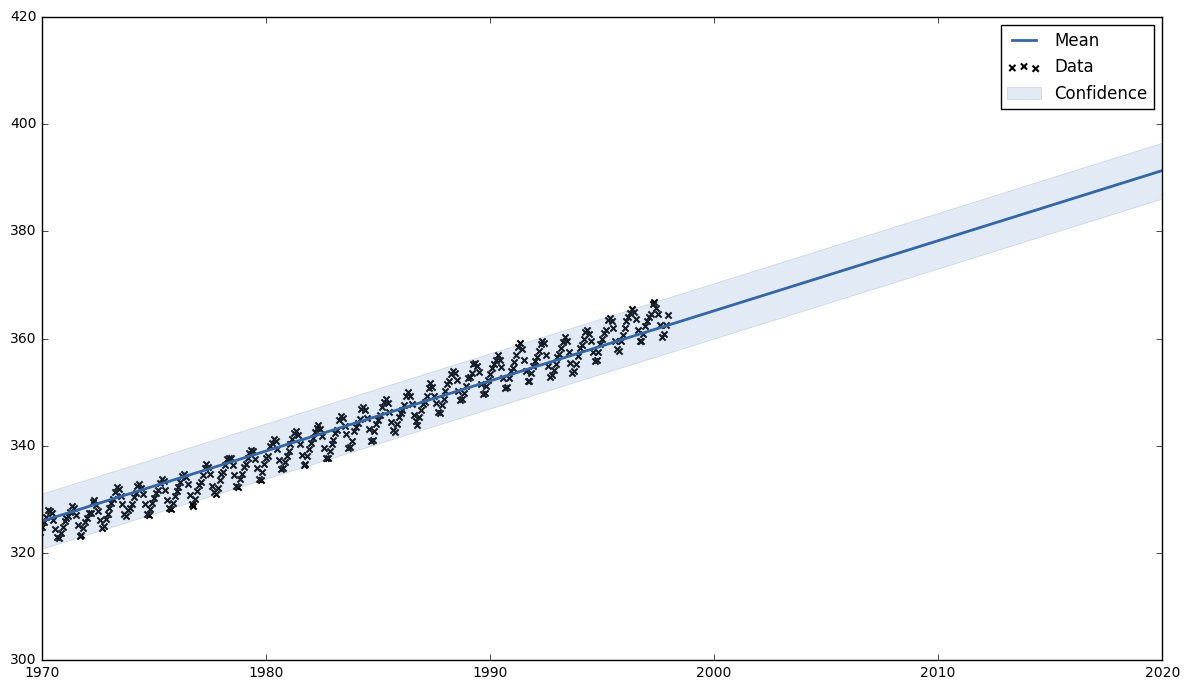

In [40]:
k2 = GPy.kern.Linear(1)+GPy.kern.Bias(1)
m2 = GPy.models.GPRegression(X,y,k2)
m2.optimize_restarts(5)
print(m2)
m2.plot((1970,2020))

Lets now combine the linear trend with a GP that has a non-degenerate covariance function.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 1038.3908512393773
Optimization restart 2/10, f = 794.4414881472478
Optimization restart 3/10, f = 794.4414815705522
Optimization restart 4/10, f = 1029.9253599614506
Optimization restart 5/10, f = 1029.925359477945
Optimization restart 6/10, f = 1029.9253614730078
Optimization restart 7/10, f = 1029.9253600714394
Optimization restart 8/10, f = 1029.9253608493134
Optimization restart 9/10, f = 617.9794241559148
Optimization restart 10/10, f = 1029.9253619655187

Name : GP regression
Objective : 617.9794241559148
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |            value  |  constraints  |  priors
  sum.rbf.variance         |    106.070898452  |      +ve      |        
  sum.rbf.lengthscale      |   0.283354333806  |      +ve      |        
  sum.linear.variances     |  0.0290469397902  |      +ve      |        
  sum.bias.variance        |    1.01204246368  |      +ve      |     

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


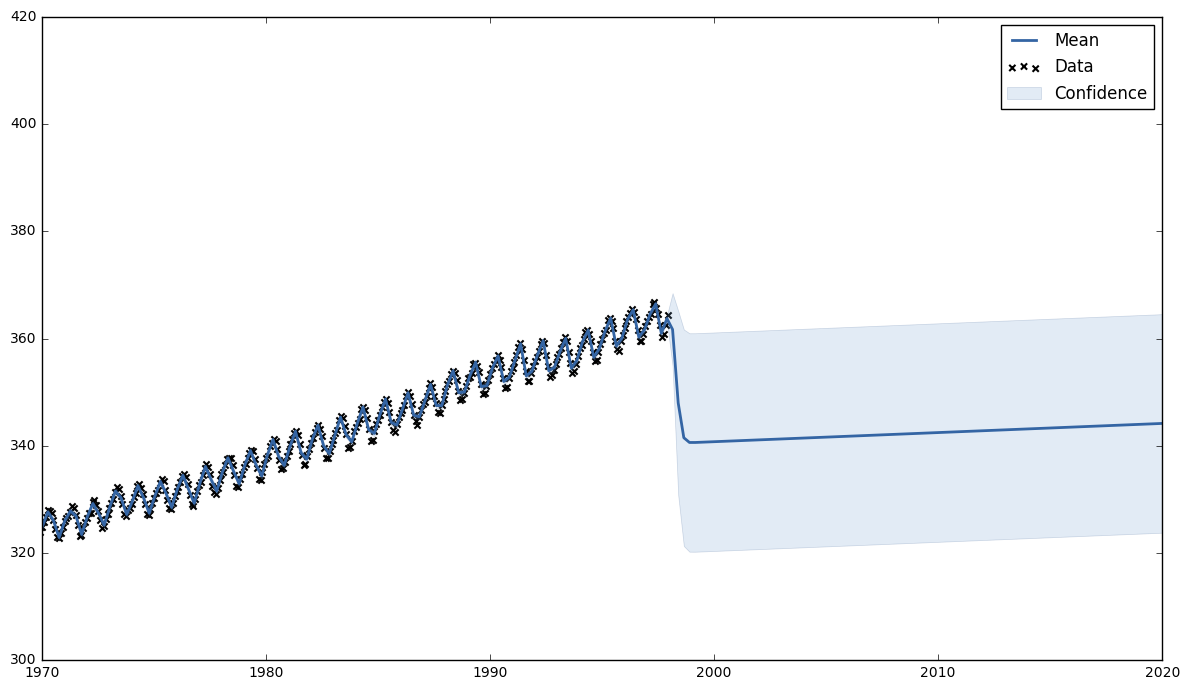

In [41]:
m3 = GPy.models.GPRegression(X,y,k1+k2)
m3.optimize_restarts(10)
print(m3)
m3.plot((1970,2020), ylim=(300,420))

That didn't seem to work very well - it's probably due to the hacky way we are fitting a linear trend here. 

### Exercise 1c:
Try fitting a linear trend using method 1 above.

In [42]:
# Write your solution here.

Another way to fix this problem is to also add a periodic term, with period 1, to represent the yearly cycle in CO2 levels.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 373.97475936968715


 /Users/pmzrdw/GPy/GPy/kern/src/rbf.py:35: RuntimeWarning:overflow encountered in square


Optimization restart 2/10, f = 127.72197991076615
Optimization restart 3/10, f = 313.7634956565304
Optimization restart 4/10, f = 287.4563459539124
Optimization restart 5/10, f = 472.19074508407954
Optimization restart 6/10, f = 474.06138778858724
Optimization restart 7/10, f = 480.2857554064179
Optimization restart 8/10, f = 474.06138713754615
Optimization restart 9/10, f = 127.72041271288225
Optimization restart 10/10, f = 127.85758591488826


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


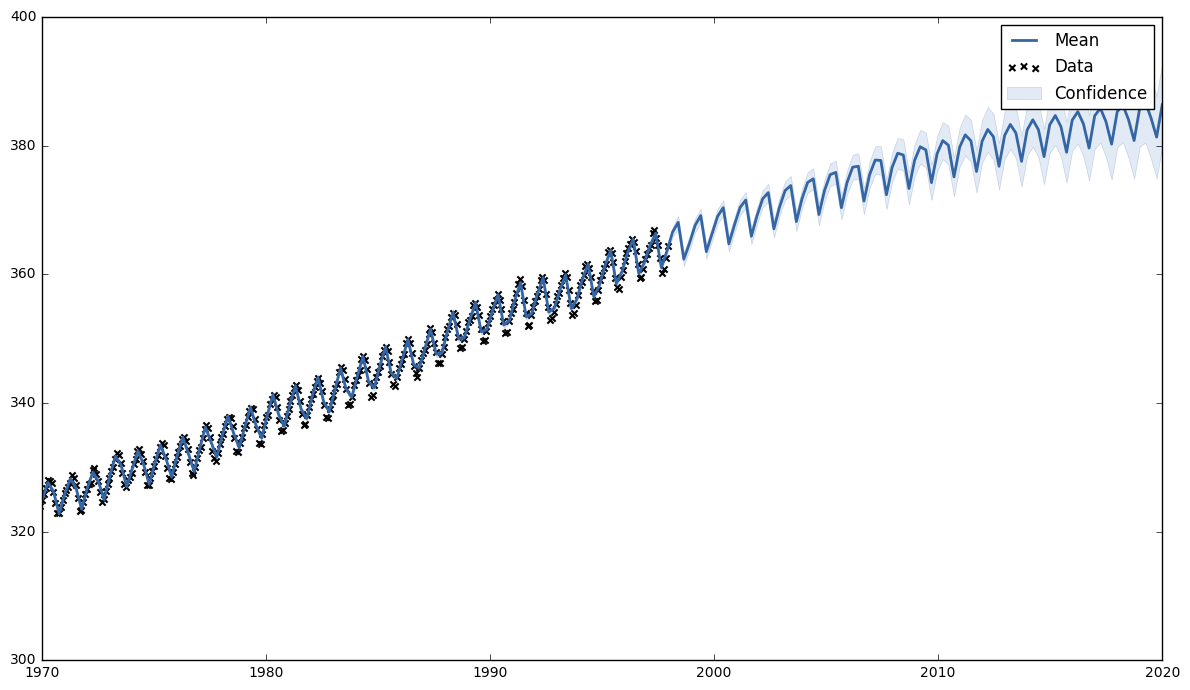

In [43]:
k3 = GPy.kern.StdPeriodic(1, lengthscale=1.3, period=1.0) * GPy.kern.RBF(1, lengthscale=90.0, variance=2.4) 
m4 = GPy.models.GPRegression(X,y,k1+k2+k3)
m4.optimize_restarts(10)
m4.plot((1970,2020))

This seems to have done the trick. Note that the kernel k3 here is a product between two individual kernels.
Note that this is a somewhat artificial example to illustrate how we can combine kernels. In practice, we may not wish to specify such a detailed kernel.

### Exercise 1c

Experiment with other combinations of kernels to see if you can get a better fit.

## 2. Multiple inputs

Normally of course, we will have multiple different covariates, i.e., our problem will not be one dimensional. Everything you have seen so far carries across without much change to the general case.

We'll look at a toy example and generate data from 
$$y=sin(x_1)*sin(x_2)+N(0, \sigma^2)$$
in the region $[-3,3]^2$

If you have the `pyDOE` package installed, we can create a maximin Latin hypercube design at which to evalute the function. These are a type of design that is close to optimal for building GP regression models. `pyDOE.lhs` by default creates a design on $[0,1]^d$ and so we have had to translated this to $[-3,3]^2$

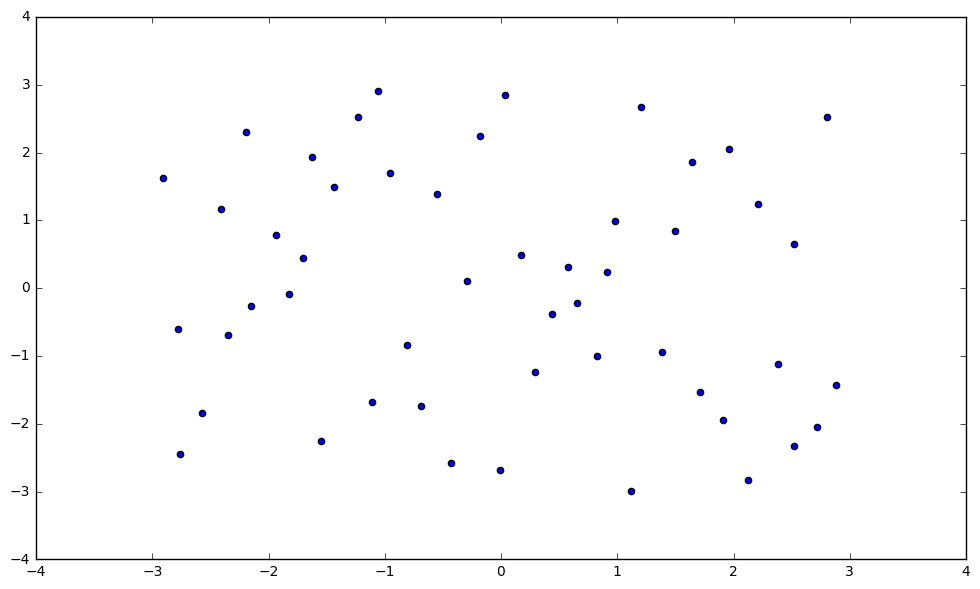

In [49]:
# sample inputs and outputs from 2d model
from pyDOE import lhs

X2 = lhs(2, samples=50, criterion='maximin')*6.-3. # you will need to have installed pyDOE for this to work. 
# Else uncomment the line below
#X2 = np.random.uniform(-3.,3.,(50,2))
Y2 = np.sin(X2[:,0:1]) * np.sin(X2[:,1:2]) + np.random.randn(50,1)*0.05

plt.scatter(X2[:,0], X2[:,1])


Now lets fit a GP and visualise the resulting fit.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


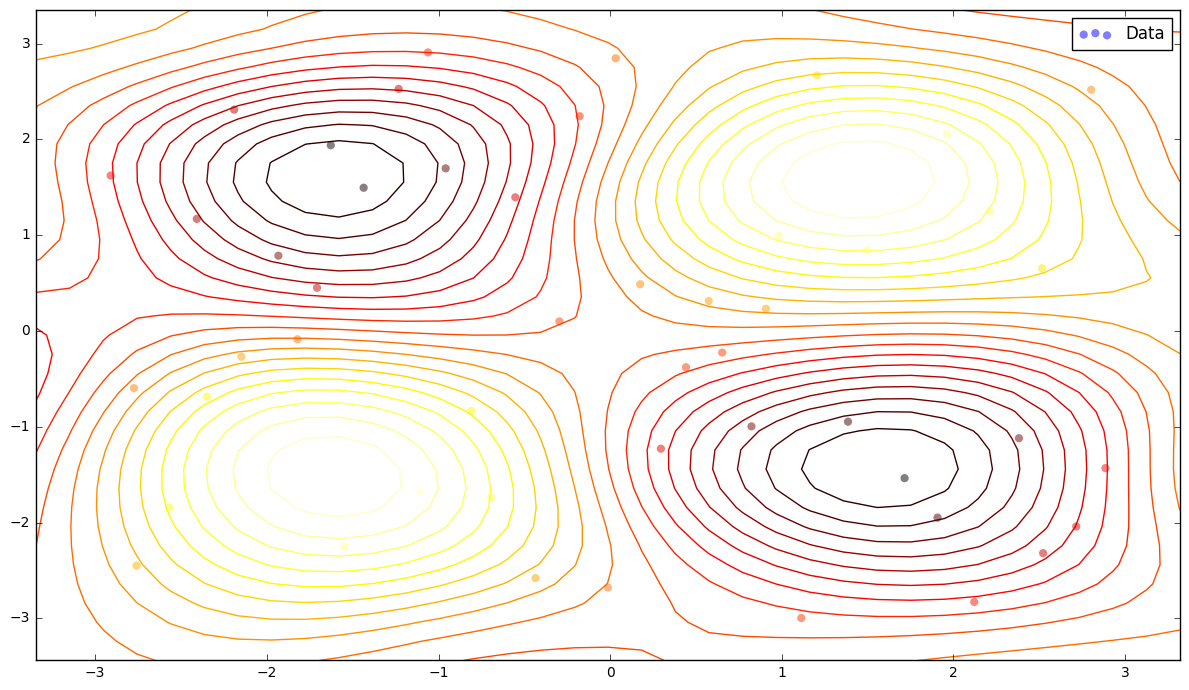

In [50]:



# define kernel, notice the number of input dimensions is now 2
ker = GPy.kern.RBF(input_dim=2, ARD=True)

# create simple GP model
m2 = GPy.models.GPRegression(X2,Y2,ker)
m2.optimize()
_ = m2.plot()

## Kernels

Kernel construction is modular. Kernels can be created seperately and then easily combined with simple operations such as addition, and multiplication, including over difference spaces. 

### Combining kernels

In GPy you can easily combine covariance functions you have created using the sum and product operators, + and *. So, for example, if we wish to combine an exponentiated quadratic covariance with a Matern 5/2 then we can write

  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat32.variance     |    0.5  |      +ve      |        
  Mat32.lengthscale  |    0.2  |      +ve      |        


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


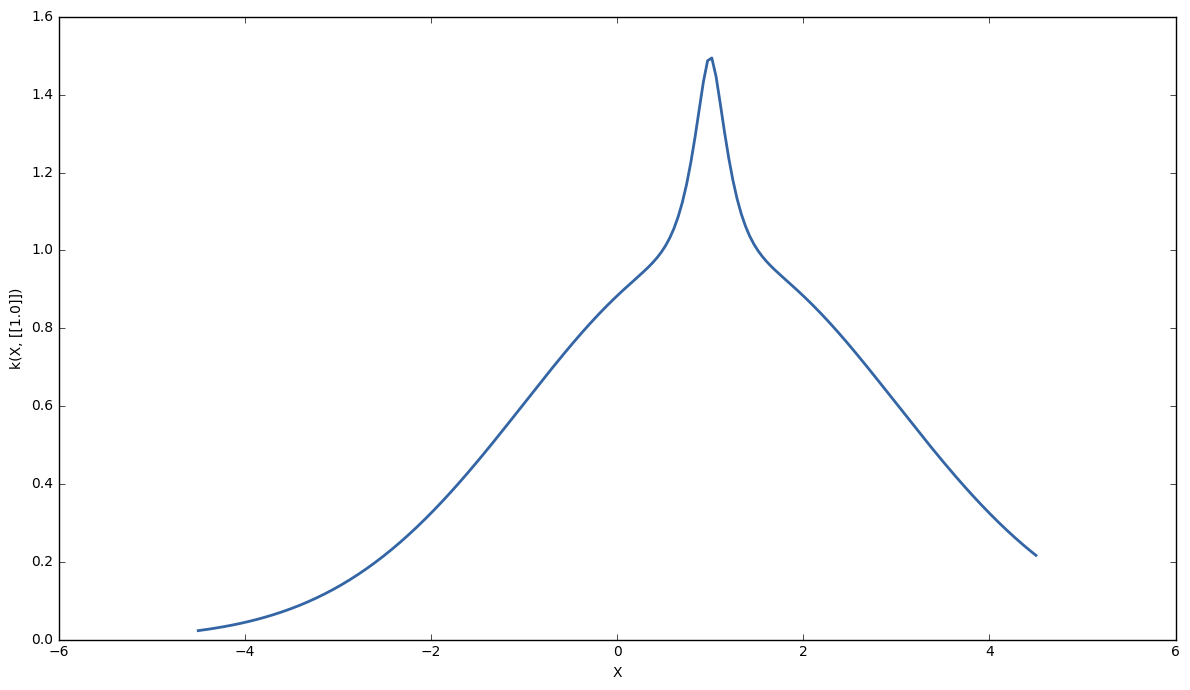

In [52]:
kern1 = GPy.kern.RBF(1, variance=1., lengthscale=2.)
kern2 = GPy.kern.Matern32(1, variance=0.5, lengthscale=0.2)
kern = kern1 + kern2
print(kern)

kern.plot()

Or if we wanted to multiply them we can write

  mul.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat32.variance     |    0.5  |      +ve      |        
  Mat32.lengthscale  |    0.2  |      +ve      |        


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


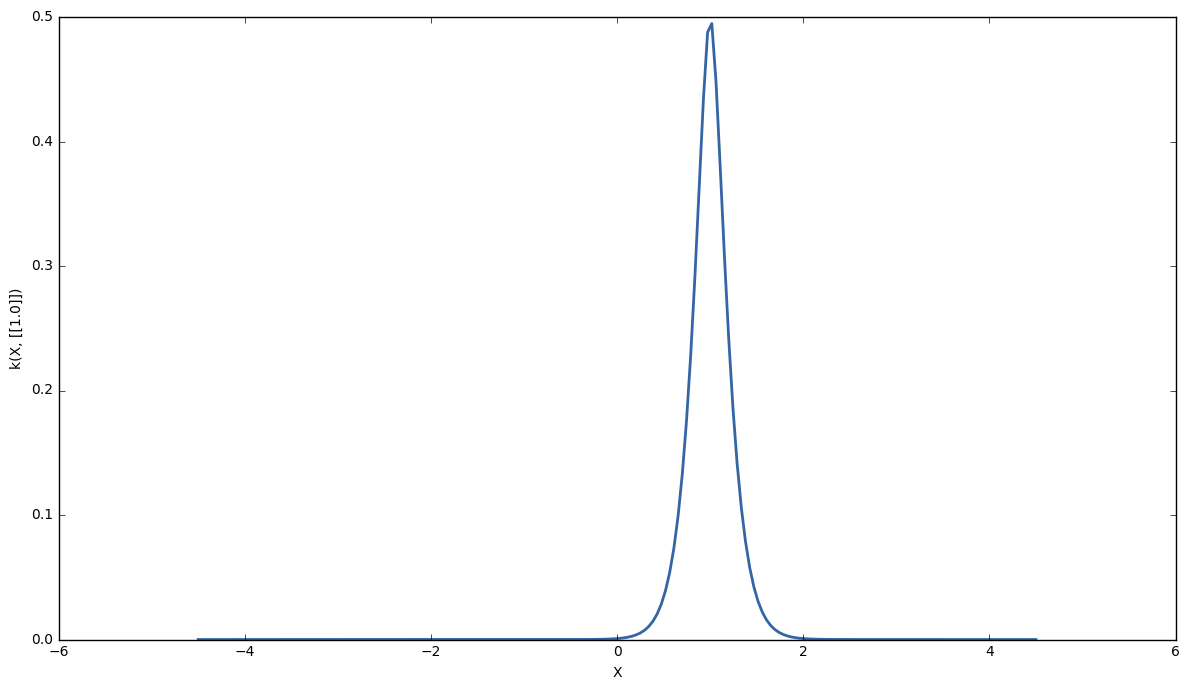

In [54]:
kern = kern1*kern2
print(kern)
kern.plot()

### Active dimensions

It may be that you only want one kernel to work one set of dimensions, and another kernel on another set. That is the two kernels work on different domains of the input. In GPy this capability is provided with active_dims argument to the kernel, which tell the kernel what to work on. Lets return back to our two-dimensional example.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


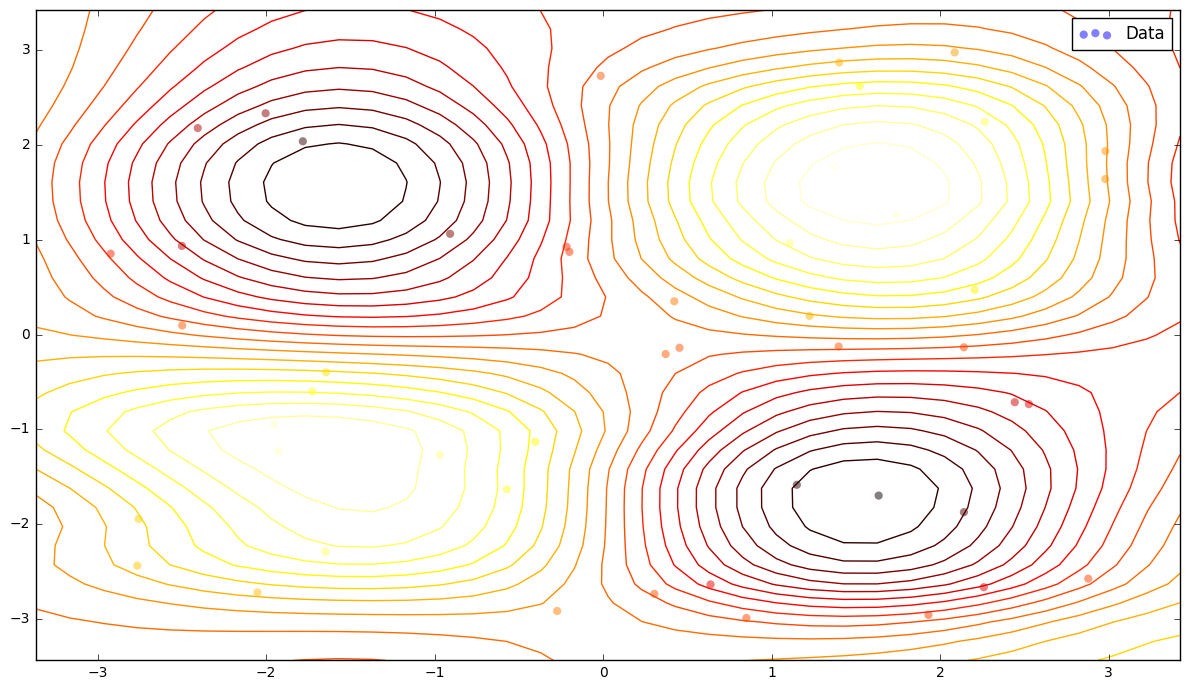

In [57]:
# sample inputs and outputs from 2d model
X2 = np.random.uniform(-3.,3.,(50,2))
Y2 = np.sin(X2[:,0:1]) * np.sin(X2[:,1:2]) + np.random.randn(50,1)*0.05

# define a sum kernel, where the first dimension is modelled with an RBF, and the second dimension is modelled with a linear kerel
ker = GPy.kern.RBF(input_dim=1, active_dims=[0]) * GPy.kern.Matern32(input_dim=1, active_dims=[1])

# create simple GP model
m2 = GPy.models.GPRegression(X2,Y2,ker)
m2.optimize()
_ = m2.plot()

If we want to plot the marginal of the model where we fix one input to a certain value, we can use "fixed_inputs", the format for which is a list of tuples, where we specify the dimension, and the fixed value.

Here we fix the first dimension (the domain of the linear kernel) to 0.2

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


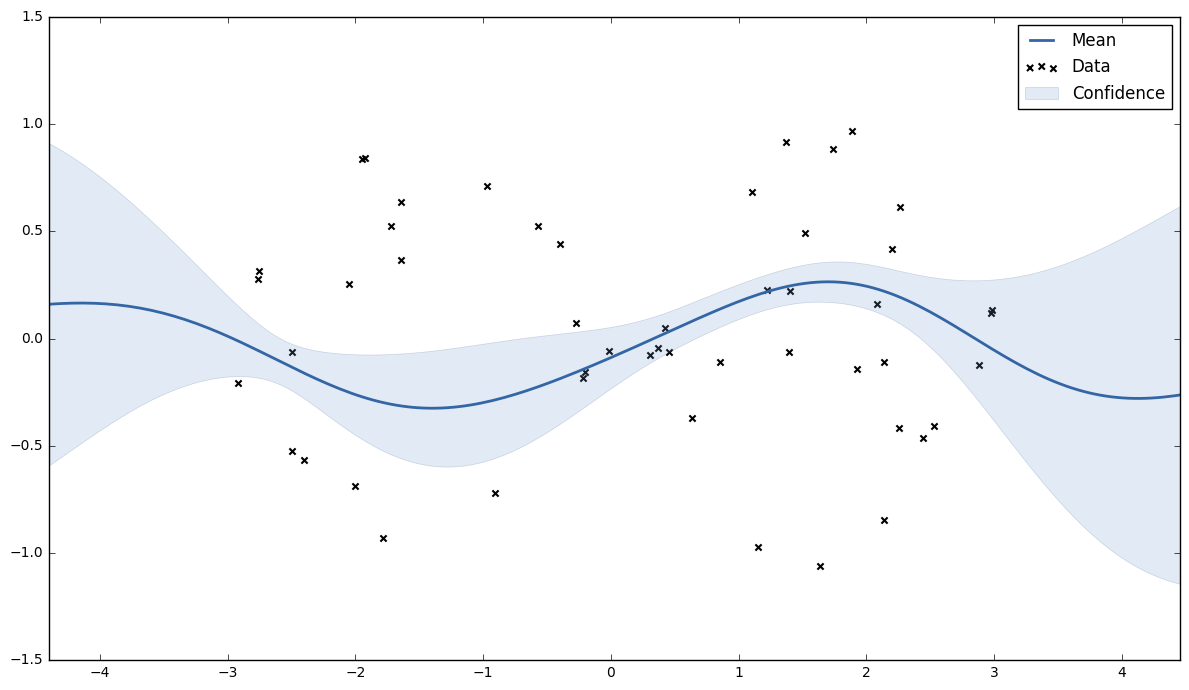

In [58]:
_ = m2.plot(fixed_inputs=[(1, 0.2)])

And then lets fix the zeroth dimension (domain of rbf) to 1.0

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


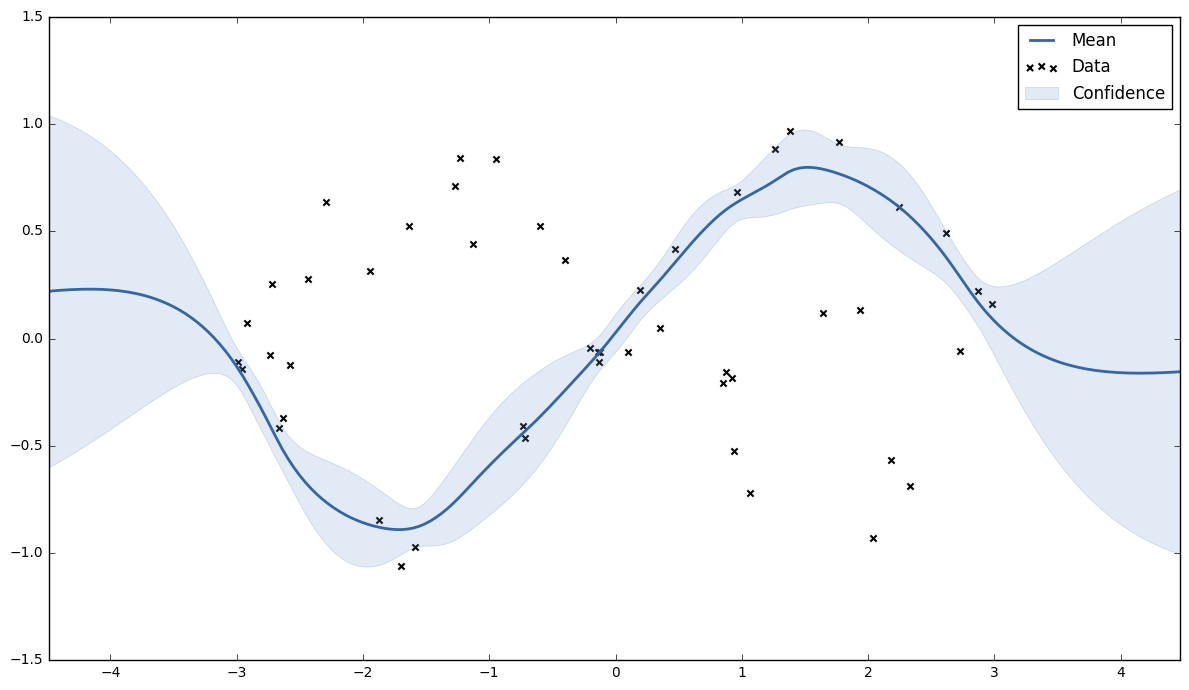

In [59]:
_ = m2.plot(fixed_inputs=[(0, 1.0)])

As we would expect, the data doesn't necessarily sit on the posterior distribution, as this is a projection of all the data onto one dimension.

### Exercise 3


Consider the [Branin](https://www.sfu.ca/~ssurjano/branin.html) function, which takes a 2d input.

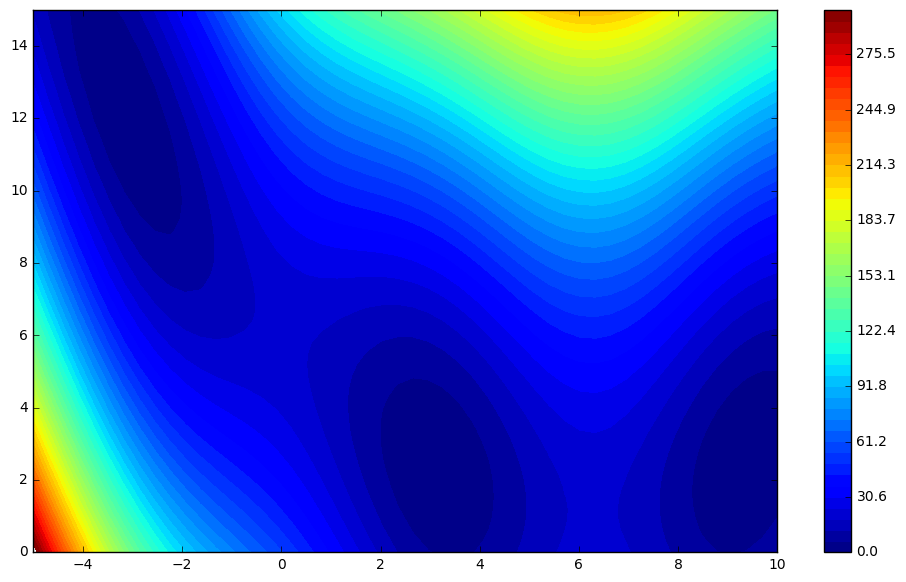

In [60]:
# Definition of the Branin test function
def branin(X):
    y = (X[:,1]-5.1/(4*np.pi**2)*X[:,0]**2+5*X[:,0]/np.pi-6)**2
    y += 10*(1-1/(8*np.pi))*np.cos(X[:,0])+10
    return(y)

# Lets plot it first on a 50*50 grid:
xg1 = np.linspace(-5,10,50)
xg2 = np.linspace(0,15,50)
Xplot = np.zeros((xg1.size * xg2.size,2))
for i,x1 in enumerate(xg1):
    for j,x2 in enumerate(xg2):
        Xplot[i+xg1.size*j,:] = [x1,x2]

Yplot = branin(Xplot)[:,None]
plt.contourf(xg1, xg2, Yplot.reshape((50, 50)), levels=np.linspace(0, 300,50))
plt.colorbar()



### Exercise 3

 Create a maximin latin hypercube design on $[-5,10]\times [0,15]$ consisting of 20 points.

Fit a GPy using 
- an RBF kernel with different length-scales in each direction. The option `ARD=True` (ARD=automatic relevance determination) tells GPy to use an anistropic kernel, i.e., to allow a different length-scale for the x1 direction and the x2 direction.

Now we will fit a GP that is the product of  different kernels in different input. Fit a GP that uses an RBF for x1, and an Matern3/2 for x2.
In this case, we want one kernel to work on one set of dimensions, and another kernel on another set. That is the two kernels work on different domains of the input. You will need to use the active_dims argument to the kernel, which tell the kernel what inputs to work on.
Notice that this is different to simply multiplying two kernels which both take two inputs. 


Finally, try using 
- a kernel that is the product of a RBF kernel for dimension 1 and a linear kernel for direction 2. Does that look sensible?
- a kernel that is the sum of an RBF kernel for dimension 1 and another RBF kernel for dimension 2. This is a type of GAM (Generalised additive model) - it is unlikely to work well here.

## 5 More Advanced: Uncertainty propagation

Let $X$ be a random variable defined over the real numbers, $\Re$, and $f(\cdot)$ be a function mapping between the real numbers $\Re \rightarrow \Re$. Uncertainty
analysis is the study of the distribution of the random variable $f ( X )$.

As an exercise here, we will assume that we are interested in the distribution of $f (U )$ where $U$ is a
random variable with uniform distribution over the input space of $f$, and where $f$ is the Branin function. We will focus on
the computation of two quantities: $E[ f (U )]$ and $P( f (U ) > 200)$.

### 4.1 Computation of E[ f (U )]

The expectation of $f (U )$ is given by $\int_x f ( x )\text{d}x$. A basic approach to approximate this
integral is to compute the mean of the 25 observations: `np.mean(Y)`. Since the points
are distributed on a grid, this can be seen as the approximation of the integral by a
rough Riemann sum. The result can be compared with the actual mean of the Branin
function which is 54.31.

Alternatively, we can fit a GP model and compute the integral of the best predictor
by Monte Carlo sampling, i.e., by simulating $U_i ~ U[-5,10]\times U[0,15]$, and then evaluating
$$I = \frac{1}{n} \sum_{i=1}^n \tilde{f}(U_i)$$ where $\tilde{f}$ denotes the GP model.

In [61]:
# Fit a GP
# Create an exponentiated quadratic plus bias covariance function
kg = GPy.kern.RBF(input_dim=2, ARD = True)
kb = GPy.kern.Bias(input_dim=2)
k = kg + kb

# Build a GP model
m = GPy.models.GPRegression(X,Y,k)

# fix the noise variance
m.likelihood.variance.fix(1e-5)

# Randomize the model and optimize
m.randomize()
m.optimize()

# Plot the resulting approximation to Brainin
# Here you get a two-d plot becaue the function is two dimensional.
m.plot()

# Compute the mean of model prediction on 1e5 Monte Carlo samples
Xp = np.random.uniform(size=(1e5,2))
Xp[:,0] = Xp[:,0]*15-5
Xp[:,1] = Xp[:,1]*15
mu, var = m.predict(Xp)
np.mean(mu)

NameError: name 'Y' is not defined

### Exercise 6

a) Has the approximation of the mean been improved by using the GP model?

b) One particular feature of GPs we have not use for now is their prediction variance. Can you use it to define some confidence intervals around the previous result?

In [ ]:
# Exercise 6 b) answer

### 4.2 Computation of $P( f (U ) > 200)$

In various cases it is interesting to look at the probability that $f$ is greater than a given
threshold. For example, assume that $f$ is the response of a physical model representing
the maximum constraint in a structure depending on some parameters of the system
such as Young’s modulus of the material (say $Y$) and the force applied on the structure
(say $F$). If the later are uncertain, the probability of failure of the structure is given by
$P( f (Y, F ) > \text{f_max} )$ where $f_\text{max}$ is the maximum acceptable constraint.

### Exercise 7

a) As previously, use the 25 observations to compute a rough estimate of the probability that $f (U ) > 200$.

In [ ]:
# Exercise 7 a) answer

b) Compute the probability that the best predictor is greater than the threshold.

In [ ]:
# Exercise 7 b) answer

c) Compute some confidence intervals for the previous result

In [ ]:
# Exercise 7 c) answer

These two values can be compared with the actual value {$P( f (U ) > 200) = 1.23\times 10^{−2}$ .

We now assume that we have an extra budget of 10 evaluations of f and we want to
use these new evaluations to improve the accuracy of the previous result.

### Exercise 8

a) Given the previous GP model, where is it interesting to add the new observations if we want to improve the accuracy of the estimator and reduce its variance?

b) Can you think about (and implement!) a procedure that updates sequentially the model with new points in order to improve the estimation of $P( f (U ) > 200)$?

### Exercise 4